In [1]:
# Install the TensorFlow package using pip
!pip install tensorflow

# Install the Kaggle package using pip
!pip install kaggle

# Import the "files" module from the "google.colab" library
from google.colab import files

# Call the "upload" method of the "files" module to upload a file to Google Colaboratory
# Once the method is called, a dialog box will appear asking the user to select the file they wish to upload
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saitejatandule","key":"ae224518108feadbac566a35ab6eb689"}'}

In [2]:
!pip install -q kaggle
#create folder kaggel
!mkdir -p ~/ .kaggle
#copy kaggle.json into kaggle folder
!cp kaggle.json ~/.kaggle/



cp: cannot create regular file '/root/.kaggle/': Not a directory


In [ ]:
#api key to get dataset
!kaggle datasets download -d debeshjha1/kvasirseg

kvasirseg.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

kaggle.json  kvasirseg.zip  sample_data


In [ ]:
!unzip kvasirseg.zip

Archive:  kvasirseg.zip
  inflating: Kvasir-SEG/1911.07069.pdf  
  inflating: Kvasir-SEG/annotated_images/cju0qkwl35piu0993l0dewei2.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0qoxqj9q6s0835b43399p4.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0qx73cjw570799j4n5cjze.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0roawvklrq0799vmjorwfv.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0rx1idathl0835detmsp84.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0s2a9ekvms080138tjjpxr.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0s690hkp960855tjuaqvv0.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0sr5ghl0nd08789uzf1raf.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0sxqiclckk08551ycbwhno.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0t4oil7vzk099370nun5h9.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0tl3uz8blh0993wxvn7ly3.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0u2g7pmnux0801vkk47ivj.jpg  
  inflating: Kvasir-SEG/annotated_images/cju0u82z3cuma0835w

# Mapping directories

In [ ]:
train_img_path = '/content/Kvasir-SEG/images'
train_mask_path = '/content/Kvasir-SEG/masks' 

# Import all the neccessary Libraries

In [ ]:
import torch
import torchvision
import torch.nn as nn
import albumentations as A
import torch.optim as optim
from torchvision import models
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from albumentations.pytorch import ToTensorV2 
from torch.utils.data import DataLoader, Dataset
import os
import cv2
import zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# Injecting the dataset

In [ ]:
train_img_lst = os.listdir('/content/Kvasir-SEG/images') 
train_mask_lst = os.listdir('/content/Kvasir-SEG/masks') 

Sort the mask and image list

In [ ]:
sorted_train_mask_lst = sorted(train_mask_lst)  
sorted_train_img_lst = sorted(train_img_lst)

# Define a function to show the images and their corresponding masks

In [ ]:
def show_images(imgs_lst,masks_lst,loops=2):
# Iterate through the loops and display the images and masks
    for i in range(loops):
        # Get the file paths of the image and the mask
        img_path = os.path.join(train_img_path,imgs_lst[i])
        mask_path = os.path.join(train_mask_path,masks_lst[i])
        # Load the image and mask as PIL images
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        # Print the image and mask file path, size and type information
        print(img_path)
        print(img.size)
        print(type(img))
        # Display the image using matplotlib
        plt.imshow(img)
        plt.show()
        # Print the mask file path, size and type information
        print(mask_path)
        print(mask.size)
        # Display the mask using matplotlib
        plt.imshow(mask)
        plt.show()
        # Print a separator line to separate different images
        print("----------------------------------------------------")

# This is a configuration class for the training process

In [ ]:
class CFG:
      # Set the device to cuda if available, otherwise use CPU
      device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
      # Set the split percentage for validation dataset
      split_pct = 0.2
      # Set the learning rate for the optimizer
      learning_rate = 3e-4
      # Set the batch size for training and validation dataset
      batch_size = 4
      # Set the number of epochs for the training process
      epochs = 3
# Set a random seed for numpy to ensure reproducibility
seed = 123
np.random.seed(seed)

# Set a random seed for PyTorch to ensure reproducibility
torch.manual_seed(seed)

# Check if GPU is available, if not, use CPU
CFG.device

device(type='cuda')

**Ensure GPU availablity**

In [ ]:
!nvidia-smi #is a command used to check the status of the GPU device (if any) available on the machine.
torch.cuda.is_available() #is a function that checks if a GPU device is available to be used with PyTorch.
tf.test.gpu_device_name() #is a TensorFlow function used to check the name of the GPU device (if any) available for use.

Sun Apr 30 14:33:59 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

'/device:GPU:0'

# Genration of random permutation using numpy 

['cju2hjrqcvi2j0801bx1i6gxg.jpg' 'cju2rlqdnoz9k0993cpjae3x0.jpg'
 'cju18kevfrojc0835bn90f1in.jpg' 'cju5vzjoslpj708186z2fusmz.jpg'
 'cju2hx006vidl0799igm81vmh.jpg']
['cju2hjrqcvi2j0801bx1i6gxg.jpg', 'cju2rlqdnoz9k0993cpjae3x0.jpg', 'cju18kevfrojc0835bn90f1in.jpg', 'cju5vzjoslpj708186z2fusmz.jpg', 'cju2hx006vidl0799igm81vmh.jpg']
/content/Kvasir-SEG/images/cju2hjrqcvi2j0801bx1i6gxg.jpg
(599, 531)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


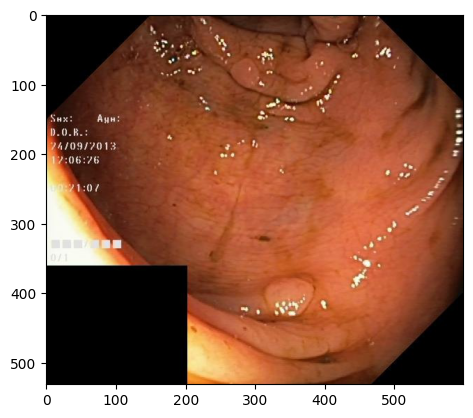

/content/Kvasir-SEG/masks/cju2hjrqcvi2j0801bx1i6gxg.jpg
(599, 531)


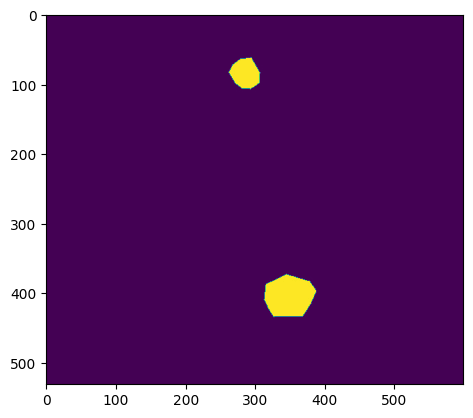

----------------------------------------------------
/content/Kvasir-SEG/images/cju2rlqdnoz9k0993cpjae3x0.jpg
(592, 531)
<class 'PIL.JpegImagePlugin.JpegImageFile'>


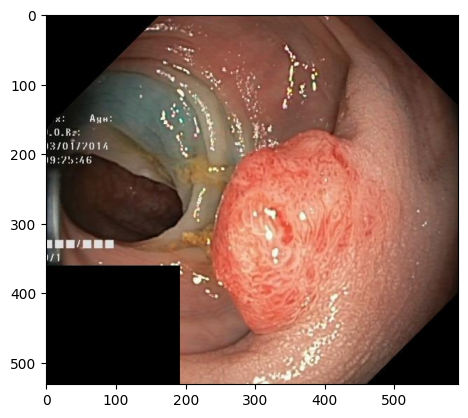

/content/Kvasir-SEG/masks/cju2rlqdnoz9k0993cpjae3x0.jpg
(592, 531)


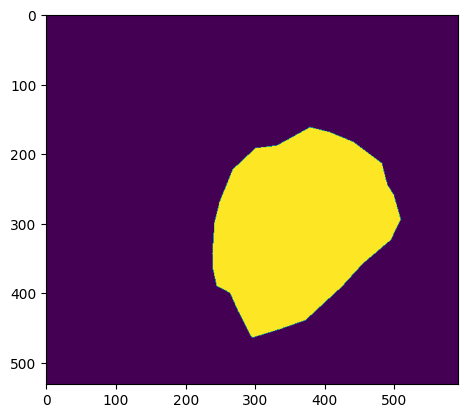

----------------------------------------------------


In [ ]:
permuted_train_img_lst = np.random.permutation(np.array(sorted_train_img_lst))
permuted_train_mask_lst = [x.replace(".jpg", ".jpg") for x in permuted_train_img_lst]
print(permuted_train_img_lst[:5])
print(permuted_train_mask_lst[:5])
show_images(permuted_train_img_lst,permuted_train_mask_lst)

In [ ]:
# Get the length of the permuted training image list
length = len(permuted_train_img_lst)

# Calculate the number of images to be used for validation
val_length = int(length * 0.2)

# Get the list of training images and masks
train_images_list = permuted_train_img_lst[val_length:]
train_masks_list = permuted_train_mask_lst[val_length:]

# Print the length of the training masks list
print(len(train_masks_list))

# Get the list of validation images and masks
val_images_list = permuted_train_img_lst[:val_length]
val_masks_list = permuted_train_mask_lst[:val_length]

# Print the length of the validation masks list
print(len(val_masks_list))

800
200


Marking the images and mask list ready for transformations

In [ ]:
class kvasirsegDataset(Dataset):
    def __init__(self, img_list, mask_list, transform=None):
        """
        Initialize the dataset with the image and mask lists and the optional transformations
        
        Args:
        img_list: List of image names
        mask_list: List of mask names
        transform: Pytorch Transformations to apply on the images and masks (optional)
        """
        self.img_list = img_list
        self.mask_list = mask_list
        self.transform = transform
        
    def __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.img_list)
    
    def __getitem__(self, index):
        """
        Returns a tuple (img, mask) of the image and the corresponding mask at the given index
        
        Args:
        index: Index of the image and mask to retrieve
        
        Returns:
        img: The image at the given index
        mask: The corresponding mask of the image at the given index
        """
        img_path = os.path.join(train_img_path, self.img_list[index])
        mask_path = os.path.join(train_mask_path, self.mask_list[index])
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        img = np.array(img)
        mask = np.array(mask)
        mask[mask==255.0] = 1.0
        
        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask,0)
            
        return img, mask


Creating transformation piplines for the training and validation datasets

In [ ]:
train_transform = A.Compose([A.Resize(572,572), 
                             A.Rotate(limit=15,p=0.1),
                             A.HorizontalFlip(p=0.5),
                             A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                             ToTensorV2()])

val_transform = A.Compose([A.Resize(572,572),
                           A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255),
                           ToTensorV2()])
train_dataset = kvasirsegDataset(train_images_list, train_masks_list, transform = train_transform)
val_dataset = kvasirsegDataset(val_images_list, val_masks_list, transform = train_transform)
idx = 200
img,mask = train_dataset[idx]
mask.shape
img.max()

tensor(1.)

Define a function to show a single image and its mask


---------------Train---------------


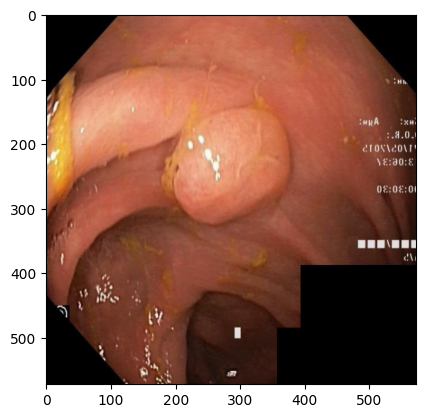

torch.Size([1, 572, 572])


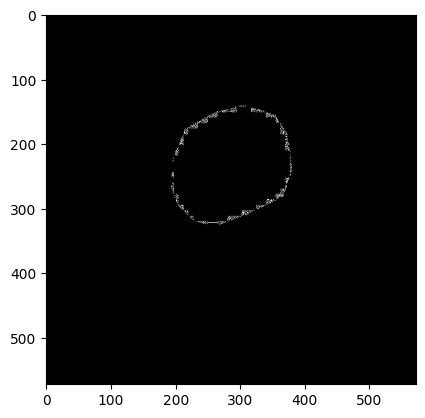

---------------Validation---------------


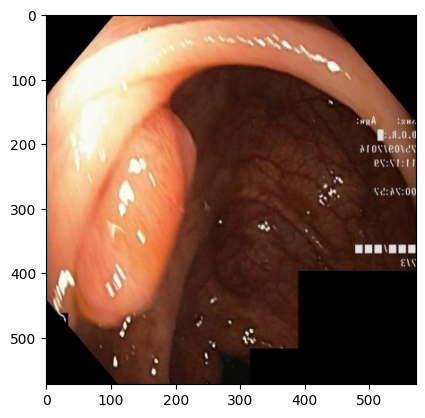

torch.Size([1, 572, 572])


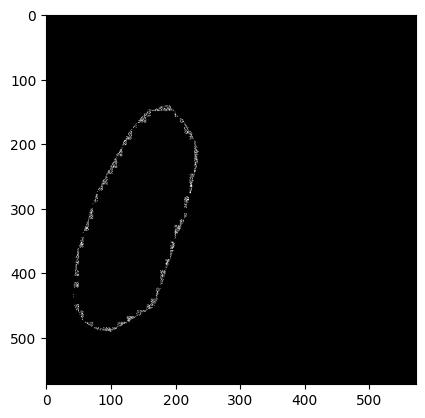

In [ ]:
def show_single_img(img,mask,index=None,train=True):
  # If an index is specified, retrieve the image and mask corresponding to the index from the specified dataset
    if index:
        if train:
            img,mask = train_dataset[index]
        else:
            img,mask = val_dataset[index]
    # Display the image with a gray colormap
    plt.imshow(img.permute(1,2,0),cmap="gray")  # Convert (3, 572, 572) -> (572, 572, 3)
    plt.show()
    # Display the mask with a gray colormap
    plt.imshow(mask.permute(1,2,0), cmap="gray")  # Convert (1, 572, 572) -> (572, 572, 1)
    # Print the shape of the mask tensor
    print(mask.shape)
    plt.show()
# Show a single image and its mask from the training dataset
print("---------------Train---------------")
show_single_img(img,mask,index=15,train=False)
# Show a single image and its mask from the validation dataset
print("---------------Validation---------------")
show_single_img(img,mask,index=15,train=True)

Setting up dataloader

In [ ]:
train_dataloader = DataLoader(train_dataset,batch_size=CFG.batch_size,shuffle=True)
val_dataloader = DataLoader(val_dataset,batch_size=CFG.batch_size,shuffle=False)


Double convolutional layer function and padding functions for UNet architecture

In [ ]:
def double_conv(in_ch, out_ch):
    conv = nn.Sequential(
        nn.Conv2d(in_channels=in_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1),
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=out_ch,out_channels=out_ch,kernel_size=3,stride=1,padding=1), 
        nn.BatchNorm2d(out_ch),                                                            
        nn.ReLU(inplace=True)
    )
    
    return conv

#def cropper(og_tensor, target_tensor):
#    og_shape = og_tensor.shape[2]
#    target_shape = target_tensor.shape[2]
#    delta = (og_shape - target_shape) // 2
#    cropped_og_tensor = og_tensor[:,:,delta:og_shape-delta,delta:og_shape-delta]
#    return cropped_og_tensor
 

def addPadding(srcShapeTensor, tensor_whose_shape_isTobechanged):

    if(srcShapeTensor.shape != tensor_whose_shape_isTobechanged.shape):
        target = torch.zeros(srcShapeTensor.shape)
        target[:, :, :tensor_whose_shape_isTobechanged.shape[2],
               :tensor_whose_shape_isTobechanged.shape[3]] = tensor_whose_shape_isTobechanged
        return target.to(CFG.device)
    return tensor_whose_shape_isTobechanged.to(CFG.device)
    
def padder(left_tensor, right_tensor): 
    # left_tensor is the tensor on the encoder side of UNET
    # right_tensor is the tensor on the decoder side  of the UNET
    
    if left_tensor.shape != right_tensor.shape:
        padded = torch.zeros(left_tensor.shape)
        padded[:, :, :right_tensor.shape[2], :right_tensor.shape[3]] = right_tensor
        return padded.to(CFG.device)
    
    return right_tensor.to(CFG.device)

Make UNet model for image segmentation with PyTorch.

In [ ]:
class UNET(nn.Module):
    def __init__(self,in_chnls, n_classes):
        super(UNET,self).__init__()
        
        self.in_chnls = in_chnls
        self.n_classes = n_classes
        
        self.max_pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.down_conv_1 = double_conv(in_ch=self.in_chnls,out_ch=64)
        self.down_conv_2 = double_conv(in_ch=64,out_ch=128)
        self.down_conv_3 = double_conv(in_ch=128,out_ch=256)
        self.down_conv_4 = double_conv(in_ch=256,out_ch=512)
        self.down_conv_5 = double_conv(in_ch=512,out_ch=1024)
        #print(self.down_conv_1)
        
        self.up_conv_trans_1 = nn.ConvTranspose2d(in_channels=1024,out_channels=512,kernel_size=2,stride=2)
        self.up_conv_trans_2 = nn.ConvTranspose2d(in_channels=512,out_channels=256,kernel_size=2,stride=2)
        self.up_conv_trans_3 = nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=2,stride=2)
        self.up_conv_trans_4 = nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=2,stride=2)
        
        self.up_conv_1 = double_conv(in_ch=1024,out_ch=512)
        self.up_conv_2 = double_conv(in_ch=512,out_ch=256)
        self.up_conv_3 = double_conv(in_ch=256,out_ch=128)
        self.up_conv_4 = double_conv(in_ch=128,out_ch=64)
        
        self.conv_1x1 = nn.Conv2d(in_channels=64,out_channels=self.n_classes,kernel_size=1,stride=1)
        
    def forward(self,x):
        
        # encoding
        x1 = self.down_conv_1(x)
        #print("X1", x1.shape)
        p1 = self.max_pool(x1)
        #print("p1", p1.shape)
        x2 = self.down_conv_2(p1)
        #print("X2", x2.shape)
        p2 = self.max_pool(x2)
        #print("p2", p2.shape)
        x3 = self.down_conv_3(p2)
        #print("X2", x3.shape)
        p3 = self.max_pool(x3)
        #print("p3", p3.shape)
        x4 = self.down_conv_4(p3)
        #print("X4", x4.shape)
        p4 = self.max_pool(x4)
        #print("p4", p4.shape)
        x5 = self.down_conv_5(p4)
        #print("X5", x5.shape)
        
        # decoding
        d1 = self.up_conv_trans_1(x5)  # up transpose convolution ("up sampling" as called in UNET paper)
        crop1 = padder(x4,d1) # padding d1 to match x4 shape
        cat1 = torch.cat([x4,crop1],dim=1) # concatenating padded d1 and x4 on channel dimension(dim 1) [batch(dim 0),channel(dim 1),height(dim 2),width(dim 3)]
        uc1 = self.up_conv_1(cat1) # 1st up double convolution
        
        d2 = self.up_conv_trans_2(uc1)
        crop2 = padder(x3,d2)
        cat2 = torch.cat([x3,crop2],dim=1)
        uc2 = self.up_conv_2(cat2)
        
        d3 = self.up_conv_trans_3(uc2)
        crop3 = padder(x2,d3)
        cat3 = torch.cat([x2,crop3],dim=1)
        uc3 = self.up_conv_3(cat3)
        
        d4 = self.up_conv_trans_4(uc3)
        crop4 = padder(x1,d4)
        cat4 = torch.cat([x1,crop4],dim=1)
        uc4 = self.up_conv_4(cat4)
        
        conv_1x1 = self.conv_1x1(uc4)
        return conv_1x1
     

 Training and Validating a UNET model for image segmentation

In [ ]:
def train_model(model,dataloader,criterion,optimizer):
    model.train()
    train_running_loss = 0.0
    for j,img_mask in enumerate(tqdm(dataloader)):
        img = img_mask[0].float().to(CFG.device)
        #print(" ----- IMAGE -----")
        #print(img)
        mask = img_mask[1].float().to(CFG.device)
        #print(" ----- MASK -----")
        #print(mask)
        
        y_pred = model(img)
        #print(" ----- Y PRED -----")
        #print(y_pred)
        #print(" ----- Y PRED SHAPE -----")#
        #print(y_pred.shape)
        optimizer.zero_grad()
        
        loss = criterion(y_pred,mask)
        
        train_running_loss += loss.item() * CFG.batch_size
        
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss / (j+1)
    return train_loss
# Validation Function

def val_model(model,dataloader,criterion,optimizer):
    model.eval()
    val_running_loss = 0
    with torch.no_grad():
        for j,img_mask in enumerate(tqdm(dataloader)):
            img = img_mask[0].float().to(CFG.device)
            mask = img_mask[1].float().to(CFG.device)
            y_pred = model(img)
            loss = criterion(y_pred,mask)
            
            val_running_loss += loss.item() * CFG.batch_size
            
        val_loss = val_running_loss / (j+1)
    return val_loss
model = UNET(in_chnls = 3, n_classes = 1).to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr = CFG.learning_rate)
criterion = nn.BCEWithLogitsLoss()
train_loss_lst = []
val_loss_lst = []  

# Define Training function and Validation function

In [ ]:
# Define training function
def train_model(model, dataloader, criterion, optimizer):
    # set the model to training mode
    model.train()
    # initialize the running loss
    train_running_loss = 0.0
    # loop through the data in the dataloader
    for j, img_mask in enumerate(tqdm(dataloader)):
        # get the image and mask from the batch
        img = img_mask[0].float().to(CFG.device)
        mask = img_mask[1].float().to(CFG.device)
        # make a prediction with the model
        y_pred = model(img)
        # zero out the gradients
        optimizer.zero_grad()
        # calculate the loss
        loss = criterion(y_pred, mask)
        # accumulate the running loss
        train_running_loss += loss.item() * CFG.batch_size
        # backpropagate the loss
        loss.backward()
        # update the weights
        optimizer.step()
    # calculate the average training loss
    train_loss = train_running_loss / (j + 1)
    # return the average training loss
    return train_loss


# Define validation function
def val_model(model, dataloader, criterion, optimizer):
    # set the model to evaluation mode
    model.eval()
    # initialize the running loss
    val_running_loss = 0
    # turn off gradient tracking
    with torch.no_grad():
        # loop through the data in the dataloader
        for j, img_mask in enumerate(tqdm(dataloader)):
            # get the image and mask from the batch
            img = img_mask[0].float().to(CFG.device)
            mask = img_mask[1].float().to(CFG.device)
            # make a prediction with the model
            y_pred = model(img)
            # calculate the loss
            loss = criterion(y_pred, mask)
            # accumulate the running loss
            val_running_loss += loss.item() * CFG.batch_size
        # calculate the average validation loss
        val_loss = val_running_loss / (j + 1)
    # return the average validation loss
    return val_loss


# Initialize model, optimizer and criterion
model = UNET(in_chnls=3, n_classes=1).to(CFG.device)
optimizer = optim.Adam(model.parameters(), lr=CFG.learning_rate)
criterion = nn.BCEWithLogitsLoss()

# Initialize empty lists to store training and validation loss
train_loss_lst = []
val_loss_lst = []


# Train the model for the specified number of epochs

In [ ]:
for i in tqdm(range(CFG.epochs)):
    # Train the model using the training dataset
    train_loss = train_model(model=model, dataloader=train_dataloader, criterion=criterion, optimizer=optimizer)
    # Evaluate the model using the validation dataset
    val_loss = val_model(model=model, dataloader=val_dataloader, criterion=criterion, optimizer=optimizer)
    # Append the training and validation losses to their respective lists
    train_loss_lst.append(train_loss)
    val_loss_lst.append(val_loss)
    # Print the current epoch's training and validation losses
    print(f" Train Loss : {train_loss:.4f}")
    print(f" Validation Loss : {val_loss:.4f}")

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : -21.6306
 Validation Loss : -56.4904


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : -59.0418
 Validation Loss : -89.1970


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

 Train Loss : -112.2183
 Validation Loss : -102.8493


In [ ]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image

class KvasirSegValDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.img_dir = os.path.join(root_dir, 'images')
        self.mask_dir = os.path.join(root_dir, 'masks')

        self.img_filenames = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.img_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.img_filenames[idx])

        img = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.transform is not None:
            img = self.transform(img)

        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

Plot the epochs to show train loss and validation loss

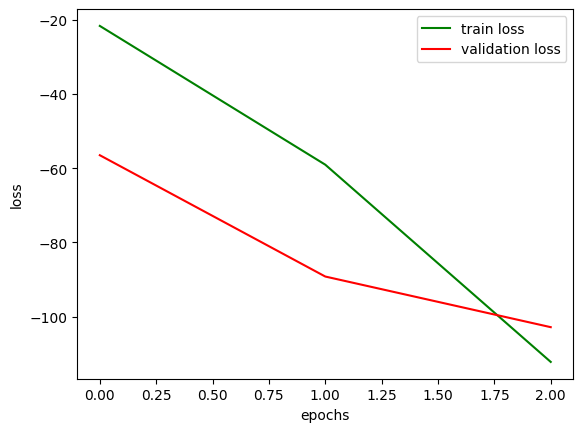

In [ ]:
# Plot the training and validation loss curves
plt.plot(train_loss_lst, color="green", label='train loss')
plt.plot(val_loss_lst, color="red", label='validation loss')
# Set the x-axis label
plt.xlabel("epochs")
# Set the y-axis label
plt.ylabel("loss")
# Display the legend
plt.legend()
# Display the plot
plt.show()

In [ ]:
# from sklearn.metrics import confusion_matrix

# # Define your model and load trained weights

# # Iterate over the validation set and generate predicted masks
# y_true = []
# y_pred = []

# for i in range(len(val_dataset)):
#     img, mask_true = val_dataset[i]
#     with torch.no_grad():
#         img = img.unsqueeze(0)  # add batch dimension
#         mask_pred = model(img.to(CFG.device)).cpu()
#     mask_pred = torch.argmax(mask_pred, dim=1).squeeze().numpy()
#     mask_true = mask_true.squeeze().numpy()
#     y_true.extend(mask_true)
#     y_pred.extend(mask_pred)

# # Generate confusion matrix
# cm = confusion_matrix(y_true, y_pred)
# print(cm)

from sklearn.metrics import confusion_matrix
import numpy as np

# Define your model and load trained weights

# Iterate over the validation set and generate predicted masks
y_true = []
y_pred = []

for i in range(len(val_dataset)):
    img, mask_true = val_dataset[i]
    with torch.no_grad():
        img = img.unsqueeze(0)  # add batch dimension
        mask_pred = model(img.to(CFG.device)).cpu()
    mask_pred = torch.argmax(mask_pred, dim=1).squeeze().numpy()
    mask_true = mask_true.squeeze().numpy()
    
    # Convert multiclass-multioutput to multiclass format
    mask_true = np.argmax(mask_true, axis=0)
    
    y_true.extend(mask_true)
    y_pred.extend(mask_pred)

# Generate confusion matrix
from sklearn.metrics import confusion_matrix

# Create dataset and dataloader
val_dataset = KvasirSegValDataset("/content/Kvasir-SEG/")
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)

# Set model to evaluation mode
model.eval()

# Iterate over the validation set and generate predicted masks
y_true = []
y_pred = []

for i, (img, mask_true) in enumerate(val_dataloader):
    with torch.no_grad():
        mask_pred = model(img.to(device)).cpu()
    mask_pred = torch.argmax(mask_pred, dim=1).squeeze().numpy()
    mask_true = mask_true.squeeze().numpy()
    y_true.extend(mask_true.flatten())
    y_pred.extend(mask_pred.flatten())

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)



AttributeError: ignored

In [ ]:
print(y_pred.count)
print(y_true.count)
# cm = confusion_matrix(y_true, y_pred)
# print(cm)

Save the Model and generate downloadable link

In [ ]:
# Define the file path to save the trained model
TRAINED_FILE = "/content/kvasir-seg-file"

# Save the state dictionary of the trained model to the specified file path
torch.save(model.state_dict(), TRAINED_FILE)

# Create a download link to the saved file for easy access
from IPython.display import FileLink
FileLink(TRAINED_FILE)

/content/kvasir-seg-file

In [ ]:
# Load the saved UNET model from the saved file
trained_model = UNET(in_chnls = 3, n_classes = 1)
trained_model.load_state_dict(torch.load(TRAINED_FILE))

# Move the model to the GPU for faster processing
trained_model = trained_model.to("cuda")

# Set the model to evaluation mode to ensure no further training is performed
trained_model.eval()

UNET(
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=

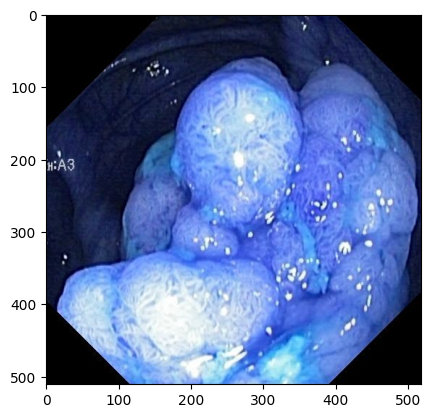

In [ ]:
# Set the path to the image to be visualized
img_path = "/content/Kvasir-SEG/images/cju17otoe119u0799nqcbl8n1.jpg"

# Read the image using OpenCV
img = cv2.imread(img_path)

# Show the image using Matplotlib
plt.imshow(img)
plt.show()


In [ ]:
# Define the image transformation pipeline for test images using Albumentations library
test_transform = A.Compose([
A.Resize(572,572), # Resize the image to (572, 572)
A.Normalize(mean=(0,0,0),std=(1,1,1),max_pixel_value=255), # Normalize the image
ToTensorV2() # Convert the image to PyTorch tensor
])

# Apply the transformation pipeline on the input image
test_image = test_transform(image = img)
img = test_image["image"].unsqueeze(0)
print(img.shape)

img = img.to("cuda")

# Convert the image to a PyTorch tensor and add an additional dimension to represent the batch size

torch.Size([1, 3, 572, 572])


In [ ]:
# Use the trained model to generate a prediction for the input image
pred = trained_model(img)

# Check the shape of the prediction
pred.shape

# Convert the prediction to a numpy array and remove the batch dimension
mask = pred.squeeze(0).cpu().detach().numpy()

# Check the shape of the mask
print(mask.shape)

# Transpose the mask to match the original image shape
mask = mask.transpose(1,2,0)

# Check the shape of the mask again
print(mask.shape)

(1, 572, 572)
(572, 572, 1)


(3, 572, 572)
-------Original Image-------


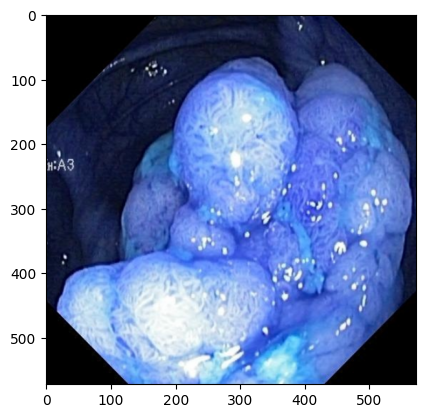

-------Image Mask-------


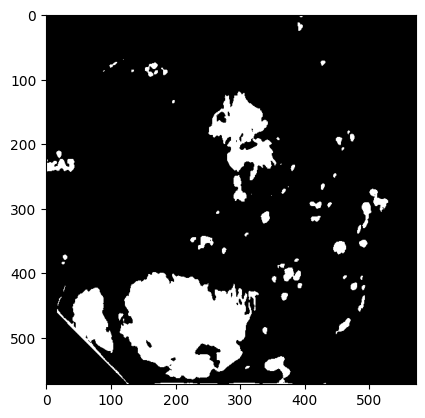

In [ ]:
# Get the input image and apply the test transformation to it
display_test_img = test_image["image"].cpu().detach().numpy()
print(display_test_img.shape)
display_test_img = display_test_img.transpose(1,2,0)

# Set negative values in the mask to 0 and values greater than 0 to 1
mask[mask<0]=0
mask[mask>0]=1

# Display the original image
print("-------Original Image-------")
plt.imshow(display_test_img, cmap="gray")
plt.show()

# Display the predicted mask
print("-------Image Mask-------")
plt.imshow(mask,cmap="gray")
plt.show()